# Aim:

In this analysis we are going to perform entity extraction on the Reuters corpus and construct entity profiles for persons, organizations and locations. 

#### Time required to run code: The entire Notebook finishes execution in about *600 seconds or 10 mins*, this is due to creating Spacy Doc objects for each document for the Reuters Dataset.


# Index
----------------------------------

## 1. Libraries needed to run notebook

## 2. Approach to solving the problem

## 3. Code

## 4. Result Analysis
### a. Top entities for all Reuters document
### b. Most Frequent Terms for popular entities

## 5. Extra Credit
### a. Approach to solving the extra credit problem

## 6. Future Scope
-----------------------


## 1. Libraries needed to run notebook:

The following libraries are required to run this Notebook:
1. NLTK
2. Spacy
3. Matplotlib
4. wordcloud

## 2. Approach for solving the Problem:

### a. Preprocessing:

The preprocessing code can be found in Step 2 of the code section.

Since each Reuters document contains new line character '\n', we remove them, since it causes hindrance for Spacy's entity extraction. To remove new lines we have used **re.sub(r"\n", "", doc_text)**. We have also replaced any spaces which occur more than once with a single space. The following code snippet was used to remove more than 1 spaces: **re.sub(r"\s+", " ", corpus_clean)**. Thus finally we get a paragraph from the Reuters document.

In the Reuters document there was an incompatible unicode character "&lt", which was replaced with "<". 

Since Reuters documents contain information about Company's stock market ticker, eg: Google has < GOOGL >, we removed these tickers by using **re.sub(r"<.*>", " ", corpus_clean)**. 
    
We also remove all special characters except for period(.), comma(,) and apostrophe('), for this we use **re.sub(r"[^A-Za-z0-9.,']", " ", corpus_clean)**.

### b. Extracting entities from a single Reuters Document:

The **extract_entities(doc_id, doc_text)** function in Step 3 of the code section performs the entity extraction after the preprocessing is complete.

We keep track of different entities like person, location and organization in different dictionaries. Using Spacy's .ents attribute we get the entity type and filter it based on "PERSON", "GPE" and "ORG". Each respective dictionary has the following structure, the **key** is the entity text, which is in the lowercase format for avoiding different forms of entity name and the **value** is a dictionary in which the **key** is document id and **value** is a list of sentences where the entity occurs.

eg: The person dictionary will be as follows: 

        {"Sheldon": 
            {"doc_id_1": 
                ["My name is Sheldon" ,
                 "Sheldon likes the color red.",
                 .....
                 ]
             },
         ......
        }

The same logic is repeated for location and organization.

### c. Storing document entities in a combined dictionary:

The Step 4 in the code section is used to store all document entities in a combined dictionary. After extracting entities from a single Reuters document we add that dictionary into a combined dictionary for which the **key** is the entity name and the **value** is a list in which the *0 index* contains a dictionary in which the **key** is document id and **value** is list of all the sentences in which the entity occurs and the *index 1* contains the *count* of the sentences in which the entity occurs across all the documents.

eg: The combined person dictionary will be as follows:

        {"Sheldon": [
                        {
                            "doc_id_1": 
                                ["My name is Sheldon" ,
                                 "Sheldon likes the color red."
                                ],
                             "doc_id_2":
                                 ["My name is also Sheldon" ,
                                 "Sheldon likes the color blue."
                                ]
                         },
                         4
                    ]
        }

The same logic is repeated for location and organization.

### d. Finding most popular entities:

The Step 5 of code section is used to get the most popular entities in the entire Reuters dataset. We have sorted each combined dictionary in descending order based on the number of times they occur in the Reuters dataset and then we return the top 500 entities.

### e. Finding the words which most frequently occur with most popular entities:

The **find_frequent_words_with_entity(top_entities, combined_entities)** function from Step 7 of the code section is used to get the words which most frequently occur with the most popular entities. We find the popular **nouns, verbs and adjectives** for a given entity.

We combine all the sentences for a popular entity into a single paragraph and also remove the entity name itself to ignore it as a frequent term. We then create a Spacy Doc object using this paragraph and filter out the stop words, numbers, dates to create a **lemmatized list** for noun, verb and adjectives individually.

We then store the top 10 most frequent tokens for noun, verb and adjective; and return a dictionary of the following format:
    
    {"entity_name":[
                    [frequent nouns], 
                    [frequent verbs],
                    [frequent adjectives]
                   ]
    }
   
This logic is used for person, location and organization.

--------------------------------------------

# 3. Code:

## Step 1) Import necessary libraries:

In [1]:
from collections import Counter
from nltk.corpus import reuters
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
import re

We are working with the Large Wikipedia English trained model, we can install it using:
    
    python -m spacy download en_core_web_lg

In [2]:
nlp = spacy.load("en_core_web_lg")

## Step 2) Preprocessing for Reuters Document:

In [3]:
def preprocess_doc_text(doc_text):
    # remove all new line characters from corpus
    corpus_clean = re.sub(r"\n", "", doc_text)

    # replace all more than 1 spaces with single space
    corpus_clean = re.sub(r"\s+", " ", corpus_clean)

    # fix weird unicode in text
    corpus_clean = re.sub(r"&lt;", "<", corpus_clean)

    # remove the market ticker name of the company
    corpus_clean = re.sub(r"<.*>", " ", corpus_clean)

    # remove all special characters from the corpus, except for period, commaand apostrophe
    corpus_clean = re.sub(r"[^A-Za-z0-9.,']", " ", corpus_clean)

    return corpus_clean

## Step 3) Function to extract the entity, document id, and relevant sentence text from the input:

In [4]:
def extract_entities(doc_id, doc_text):

    # create spacy doc object
    analyzed_doc = nlp(preprocess_doc_text(doc_text))

    doc_persons = {}
    doc_organizations = {}
    doc_locations = {}

    # analyzing entities for a document
    for entity in analyzed_doc.ents:
        entity_text = entity.text.lower().strip()
        sentence = entity.sent.text.strip()

        if entity_text != "":

            # for persons
            if entity.label_ == "PERSON":
                if entity_text in doc_persons.keys():
                    # present
                    doc_persons[entity_text][doc_id].append(sentence)
                else:
                    # not present
                    doc_persons[entity_text] = {doc_id: [sentence]}

            # for locations
            if entity.label_ == "GPE":
                if entity_text in doc_locations.keys():
                    # present
                    doc_locations[entity_text][doc_id].append(sentence)
                else:
                    # not present
                    doc_locations[entity_text] = {doc_id: [sentence]}

            # for organizations
            if entity.label_ == "ORG":
                if entity_text in doc_organizations.keys():
                    # present
                    doc_organizations[entity_text][doc_id].append(sentence)
                else:
                    # not present
                    doc_organizations[entity_text] = {doc_id: [sentence]}

    return doc_persons, doc_organizations, doc_locations

## Step 4) Calling extract_entities on all Reuters documents:

In [5]:
num_docs = len(reuters.fileids())

combined_persons = {}
combined_organizations = {}
combined_locations = {}

for doc_id in reuters.fileids()[:num_docs]:

    persons, organizations, locations = extract_entities(
        doc_id, reuters.open(doc_id).read()
    )

    for person in persons.keys():
        if person in combined_persons.keys():
            # present
            combined_persons[person][0][doc_id] = persons[person][doc_id]
            # update frequency of entity occuring across all documents
            combined_persons[person][1] += len(persons[person][doc_id])
        else:
            # not present
            combined_persons[person] = [persons[person], len(persons[person][doc_id])]

    for organization in organizations.keys():
        if organization in combined_organizations.keys():
            # present
            combined_organizations[organization][0][doc_id] = organizations[organization][doc_id]
            combined_organizations[organization][1] += len(organizations[organization][doc_id])
        else:
            # not present
            combined_organizations[organization] = [
                organizations[organization],
                len(organizations[organization][doc_id]),
            ]

    for location in locations.keys():
        if location in combined_locations.keys():
            # present
            combined_locations[location][0][doc_id] = locations[location][doc_id]
            combined_locations[location][1] += len(locations[location][doc_id])
        else:
            # not present
            combined_locations[location] = [
                locations[location],
                len(locations[location][doc_id]),
            ]


## Step 5) To get the most popular entities based on number of times they occur in entire Reuters dataset:

In [6]:
def find_most_popular_entities(entity_dictionary):
    list_of_dictionary_keys_with_most_mentions = []

    for k, v in sorted(entity_dictionary.items(), key=lambda item: -item[1][1]):
        # store the entity name and its frequency
        list_of_dictionary_keys_with_most_mentions.append((k, v[1]))

    # return the top 500 entities
    return list_of_dictionary_keys_with_most_mentions[:500]

## Step 6) Invoke top entity mention finder:

In [7]:
top_persons = find_most_popular_entities(combined_persons)
top_organizations = find_most_popular_entities(combined_organizations)
top_locations = find_most_popular_entities(combined_locations)

## Step 7) Analyzing most popular entities to determine what words they most frequently occur with:

In [8]:
def find_frequent_words_with_entity(top_entities, combined_entities):
    most_popular_terms = {}

    # finally, now find the most frequent tokens associated with the entities
    for entity, frequency in top_entities:
        # using the top_persons list find get the values in combined_persons
        entity_details, entity_count = combined_entities[entity]

        # store all the sentences across documents into a common list
        common_sent = []
        for statements in list(entity_details.values()):
            common_sent.extend(statements)

        # get all the sentences into a paragraph
        joined_sentence = " ".join(common_sent)

        # we remove the entity name itself, to avoid counting it
        sentence_processed = re.sub(entity, "", joined_sentence, flags=re.IGNORECASE)

        # lower case the sentence for frequency counting
        final_paragraph = nlp(sentence_processed.lower())

        # store the verb, noun and adjective
        noun_words = []
        verb_words = []
        adjective_words = []

        for token in final_paragraph:
            # remove all stop words and symbols
            # remove all numbers and dates
            # lemmatize all words
            if (
                token.is_stop != True
                and token.is_punct != True
                and token.like_num != True
                and token.text.strip() != ""
            ):
                if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                    noun_words.append(token.lemma_)
                elif token.pos_ == "ADJ":
                    adjective_words.append(token.lemma_)
                elif token.pos_ == "VERB":
                    verb_words.append(token.lemma_)

        # find frequency
        noun_word_freq = Counter(noun_words)
        verb_word_freq = Counter(verb_words)
        adjective_word_freq = Counter(adjective_words)

        # return the top 10 tokens
        noun_common_words = noun_word_freq.most_common(10)
        verb_common_words = verb_word_freq.most_common(10)
        adjective_common_words = adjective_word_freq.most_common(10)

        # fill this dictionary with all the words in the context of the entity
        most_popular_terms[entity] = [
            # 0 = nouns and proper nouns
            [frequent_words[0] for frequent_words in noun_common_words],
            # 1 verbs
            [frequent_words[0] for frequent_words in verb_common_words],
            # 2 adjectives
            [frequent_words[0] for frequent_words in adjective_common_words],
        ]

    return most_popular_terms

In [9]:
# finally, now find the most frequent tokens associated with the entities
person_most_popular_terms = find_frequent_words_with_entity(
    top_persons, combined_persons
)

organization_most_popular_terms = find_frequent_words_with_entity(
    top_organizations, combined_organizations
)

location_most_popular_terms = find_frequent_words_with_entity(
    top_locations, combined_locations
)

## Step 8) Function which creates word cloud based on frequency of terms

In [10]:
def create_word_cloud(entity_with_frequencies):
    wordcloud = WordCloud(
        background_color="white", width=1000, height=500
    ).generate_from_frequencies(dict(entity_with_frequencies))

    plt.figure(figsize=(13, 13), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()

## 4. Result Analysis:

### a. Top entities for all Reuters document

We have found the top 500 entities across all documents for person, location and organization entity labels. The following word cloud represents the results:

i. Top 500 frequently occuring Persons:

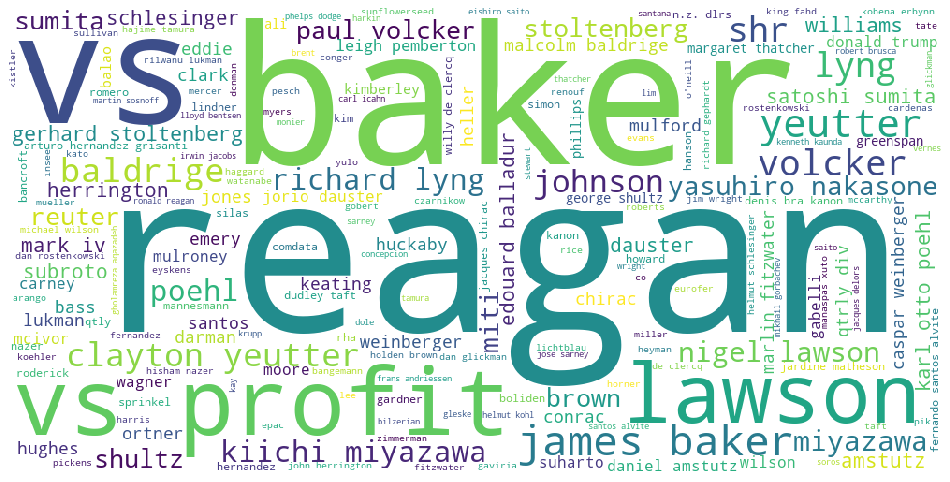

In [11]:
create_word_cloud(top_persons)

ii. Top 500 frequently occuring Locations:

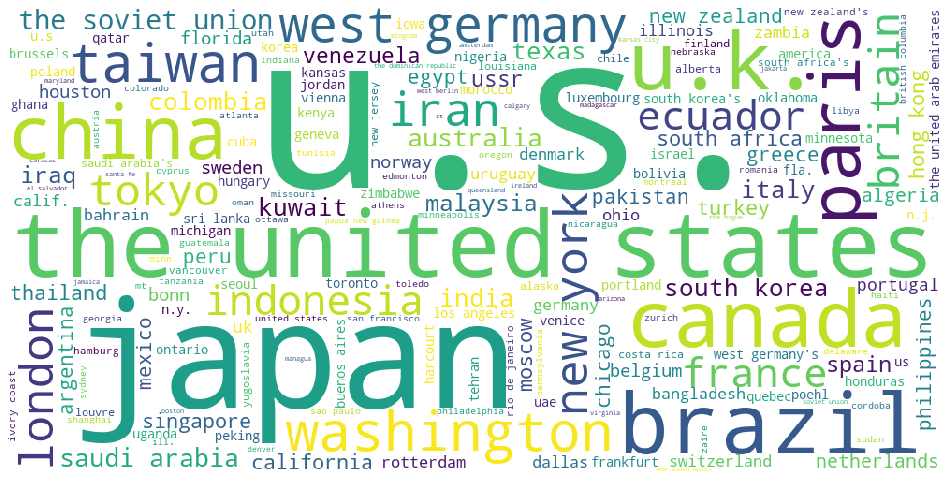

In [12]:
create_word_cloud(top_locations)

iii. Top 500 frequently occuring Organizations:

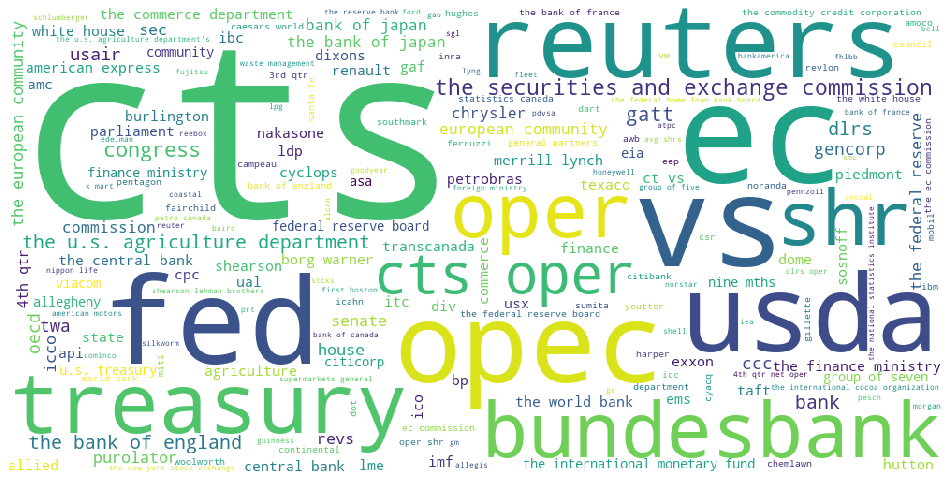

In [13]:
create_word_cloud(top_organizations)

### b. Most Frequent Terms for popular entities

We discuss the most frequent terms for the top 3 persons, locations and organizations.

The top 3 Persons are:

In [14]:
top_persons[:3]

[('reagan', 382), ('baker', 275), ('vs', 165)]

And the most frequently occurring terms with these entities are given below. 

**Note:** Inside the nested list, the first list is for NOUNS, the second list is for VERBS and third list is for ADJECTIVES

In [15]:
for entity_name, count in top_persons[:3]:
    print("------------------------------------------------")
    print("The entity name is:", entity_name)
    print()
    print(
        "Most popular Nouns associate are: ", person_most_popular_terms[entity_name][0]
    )
    print()
    print(
        "Most popular Verbs associate are: ", person_most_popular_terms[entity_name][1]
    )
    print()
    print(
        "Most popular Adjectives associate are: ",
        person_most_popular_terms[entity_name][2],
    )
    print()

------------------------------------------------
The entity name is: reagan

Most popular Nouns associate are:  ['u.s', 'president', 'trade', 'administration', 'japan', 'bill', 'house', 'oil', 'official', 'agreement']

Most popular Verbs associate are:  ['say', 'impose', 'urge', 'retaliate', 'require', 'open', 'announce', 'propose', 'protect', 'include']

Most popular Adjectives associate are:  ['japanese', 'foreign', 'economic', 'unfair', 'new', 'american', 'protectionist', 'free', 'strong', 'domestic']

------------------------------------------------
The entity name is: baker

Most popular Nouns associate are:  ['treasury', 'u.s', 'rate', 'hughes', 'currency', 'dollar', 'merger', 'agreement', 'meeting', 'policy']

Most popular Verbs associate are:  ['say', 'see', 'tell', 'agree', 'decline', 'go', 'think', 'comment', 'propose', 'meet']

Most popular Adjectives associate are:  ['german', 'west', 'economic', 'international', 'monetary', 'japanese', 'current', 'consistent', 'great', 'sh

The top 3 Locations are:

In [16]:
top_locations[:3]

[('u.s.', 4289), ('japan', 1530), ('the united states', 580)]

And the most frequently occurring terms with these entities are given below. 

**Note:** Inside the nested list, the first list is for NOUNS, the second list is for VERBS and third list is for ADJECTIVES

In [17]:
for entity_name, count in top_locations[:3]:
    print("------------------------------------------------")
    print("The entity name is:", entity_name)
    print()
    print(
        "Most popular Nouns associate are: ",
        location_most_popular_terms[entity_name][0],
    )
    print()
    print(
        "Most popular Verbs associate are: ",
        location_most_popular_terms[entity_name][1],
    )
    print()
    print(
        "Most popular Adjectives associate are: ",
        location_most_popular_terms[entity_name][2],
    )
    print()

------------------------------------------------
The entity name is: u.s.

Most popular Nouns associate are:  ['trade', 'japan', 'market', 'pct', 'year', 'dlr', 'dollar', 'export', 'oil', 'official']

Most popular Verbs associate are:  ['say', 'rise', 'expect', 'tell', 'fall', 'buy', 'increase', 'report', 'add', 'sell']

Most popular Adjectives associate are:  ['japanese', 'foreign', 'high', 'major', 'canadian', 'economic', 'new', 'iranian', 'low', 'large']

------------------------------------------------
The entity name is: japan

Most popular Nouns associate are:  ['u.s', 'trade', 'market', 'pct', 'year', 'official', 'surplus', 'united', 'states', 'import']

Most popular Verbs associate are:  ['say', 'cut', 'open', 'tell', 'rise', 'buy', 'reduce', 'increase', 'fall', 'continue']

Most popular Adjectives associate are:  ['ese', 'economic', 'domestic', 'foreign', 'large', 'major', 'current', 'high', 'new', 'international']

------------------------------------------------
The entity n

The top 3 Organizations are:

In [18]:
top_organizations[:3]

[('cts', 6115), ('ec', 883), ('vs', 711)]

And the most frequently occurring terms with these entities are given below. 

**Note:** Inside the nested list, the first list is for NOUNS, the second list is for VERBS and third list is for ADJECTIVES

In [19]:
for entity_name, count in top_organizations[:3]:
    print("------------------------------------------------")
    print("The entity name is:", entity_name)
    print()
    print(
        "Most popular Nouns associate are: ",
        organization_most_popular_terms[entity_name][0],
    )
    print()
    print(
        "Most popular Verbs associate are: ",
        organization_most_popular_terms[entity_name][1],
    )
    print()
    print(
        "Most popular Adjectives associate are: ",
        organization_most_popular_terms[entity_name][2],
    )
    print()

------------------------------------------------
The entity name is: cts

Most popular Nouns associate are:  ['shr', 'loss', 'mln', 'profit', 'share', 'qtr', 'net', 'dlr', 'div', 'oper']

Most popular Verbs associate are:  ['say', 'set', 'include', 'exclude', 'raise', 'dilute', 'end', 'rev', 'declare', 'report']

Most popular Adjectives associate are:  ['net', 'quarterly', '4th', 'prior', 'extraordinary', '1st', 'payable', 'regular', '3rd', 'fiscal']

------------------------------------------------
The entity name is: ec

Most popular Nouns associate are:  ['trade', 'u.s', 'community', 'tonne', 'export', 'minister', 'oil', 'tax', 'sugar', 'country']

Most popular Verbs associate are:  ['say', 'propose', 'tell', 'agree', 'meet', 'import', 'add', 'sell', 'offer', 'impose']

Most popular Adjectives associate are:  ['european', 'japanese', 'new', 'foreign', 'french', 'free', 'non', 'agricultural', 'spanish', 'white']

------------------------------------------------
The entity name is: vs

## 5. Extra Credit

## To determine which persons, organizations, and locations most frequently occur in the same sentences.

### a. Approach for solving Extra Credit:

We store the most frequently occuring person, location and organizations in a sentence using the following data structure:

    {"sentence_1":[
                   {person1 : count_of_person1_in_sentence_1, person2: ....},
                   {location1 : count_of_location1_in_sentence_1, location2: ....},
                   {organization1 : count_of_organization1_in_sentence_1, organization2: ....},
                  ],
     "sentence_2:".....}

### Code:

In [20]:
def frequency_of_entities_in_sentence(doc_id, doc_text):

    sentence_dict = {}

    corpus_cleaned = preprocess_doc_text(doc_text)

    # create doc object
    analyzed_doc = nlp(corpus_cleaned)

    for entity in analyzed_doc.ents:
        entity_text = entity.text.strip()
        sentence = entity.sent.text.strip()

        if entity_text != "":
            if sentence not in sentence_dict.keys():
                # not present then initialize
                sentence_dict[sentence] = [
                    {},  # person
                    {},  # location
                    {},  # organization
                ]

            # for persons
            if entity.label_ == "PERSON":
                if entity_text in sentence_dict[sentence][0].keys():
                    # present then increment count of that entity
                    sentence_dict[sentence][0][entity_text] += 1
                else:
                    # not present
                    sentence_dict[sentence][0][entity_text] = 1

            # for locations
            if entity.label_ == "GPE":
                if entity_text in sentence_dict[sentence][1].keys():
                    # present then increment count of that entity
                    sentence_dict[sentence][1][entity_text] += 1
                else:
                    # not present
                    sentence_dict[sentence][1][entity_text] = 1

            # for organizations
            if entity.label_ == "ORG":
                if entity_text in sentence_dict[sentence][2].keys():
                    # present then increment count of that entity
                    sentence_dict[sentence][2][entity_text] += 1
                else:
                    # not present
                    sentence_dict[sentence][2][entity_text] = 1

    return sentence_dict

In [21]:
# Determine which persons, organizations, and locations most frequently occur in the same sentences.
combined_sentence_dict = {}

# here we have restricted the code to run for 10 documents only
for doc_id in reuters.fileids()[:10]:

    sentence_dicts = frequency_of_entities_in_sentence(
        doc_id, reuters.open(doc_id).read()
    )

    for sentence_with_frequent_entity in sentence_dicts.keys():
        if sentence_with_frequent_entity in combined_sentence_dict.keys():
            # present
            # update the person dictionaries of that sentence
            combined_sentence_dict[sentence_with_frequent_entity][0].update(
                sentence_dicts[sentence_with_frequent_entity][0]
            )
            # update the location dictionaries of that sentence
            combined_sentence_dict[sentence_with_frequent_entity][1].update(
                sentence_dicts[sentence_with_frequent_entity][1]
            )
            # update the organization dictionaries of that sentence
            combined_sentence_dict[sentence_with_frequent_entity][2].update(
                sentence_dicts[sentence_with_frequent_entity][2]
            )
        else:
            # not present
            # add the combined dictionary
            combined_sentence_dict[sentence_with_frequent_entity] = sentence_dicts[
                sentence_with_frequent_entity
            ]

In [22]:
def most_frequently_occuring_entities(combined_sentence_dict):
    result = {}
    for key, value in combined_sentence_dict.items():

        entities = [{}, {}, {}]

        # person
        entities[0] = sorted(value[0].items(), key=lambda item: -item[1])[:5]

        # location
        entities[1] = sorted(value[1].items(), key=lambda item: -item[1])[:5]

        # organization
        entities[2] = sorted(value[2].items(), key=lambda item: -item[1])[:5]

        result[key] = entities

    return result

In [23]:
most_frequently_occuring_entities_in_sentences = most_frequently_occuring_entities(
    combined_sentence_dict
)

For the first 10 sentence the top 3 most frequently occuring person, location and organization are as follows:

In [24]:
i = 0
for sentence, entities in most_frequently_occuring_entities_in_sentences.items():
    print("---------------------")
    print("Sentence is :", sentence)
    print()
    print("Frequently Occuring Persons in sentence:", entities[0])
    print("Frequently Occuring Locations in sentence:", entities[1])
    print("Frequently Occuring Organizations in sentence:", entities[2])
    print()
    # to print only the first 10 sentences
    i += 1
    if i == 10:
        break

---------------------
Sentence is : ASIAN EXPORTERS FEAR DAMAGE FROM U.S. JAPAN RIFT Mounting trade friction between the U.S.

Frequently Occuring Persons in sentence: []
Frequently Occuring Locations in sentence: [('U.S.', 2), ('JAPAN', 1)]
Frequently Occuring Organizations in sentence: [('RIFT Mounting', 1)]

---------------------
Sentence is : And Japan has raised fears among many of Asia's exporting nations that the row could inflict far reaching economic damage, businessmen and officials said.

Frequently Occuring Persons in sentence: []
Frequently Occuring Locations in sentence: [('Japan', 1)]
Frequently Occuring Organizations in sentence: []

---------------------
Sentence is : They told Reuter correspondents in Asian capitals a U.S. Move against Japan might boost protectionist sentiment in the U.S.

Frequently Occuring Persons in sentence: [('Reuter', 1)]
Frequently Occuring Locations in sentence: [('U.S.', 2), ('Japan', 1)]
Frequently Occuring Organizations in sentence: []

--

## 6. Future Scope

In the future we would like to enhance the code by doing the following tasks:
    1. Improve runtime of code
    2. Handle different forms of same entity
    3. Overcome same entities being tagged differently